## Yennie Jun Fundamentals of Social Data Science Summative

**TO DO** Make sure everything is in APA format

- [ ] references
- [ ] appendix - make sure even when I refer to appendix, make sure in APA
- [ ] change dates to after january, not just after august

# Part 1

## Setup [500 words]

**Setup** 500 words, one Jupyter notebook cell: 

Lit review, set the scene, theory, research question, background research

The research question I would like to ask:

```
Does the representation of women in a country's government correlate with that country's response to coronavirus?
```

The Women's Power Index, compiled by the Council on Foreign Relations [cite], ranks 193 UN member states in relation to gender parity in political participation. The index is an amalgamation of several different indexes, including the proportion of women who serve as heads of state, in national parliaments, in local governments. I will be using the Women's Power Index (`wpi` below).

The Government's response will be measured by a seriers of indices in the Oxford Covid-19 Government Response Tracker [cite]




## Data Analysis [750 words]

**Data Analysis** 750 words

Methods
- How are you going to start digging in?
- As well explained as possible, all the ways you will go about doing this "digging through" data wrangling
- All of the choices you will have to make (i.e. missing data)
- why did you make a certain decision? 
- One might think it justified to understand why a certain variable is more important to keep and certain variables more important to let go, how is it necessray for your explanation?

In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import psycopg2
import numpy as np
import re

sns.set()

In [162]:
import altair as alt


In [241]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [243]:
# loading govtrack table
sql_command = """SELECT * FROM government_response WHERE date < '2020-04-01' ORDER by date DESC"""
df_govtrack = pd.read_sql(sql_command, conn)

# to datetime
df_govtrack.date = pd.to_datetime(df_govtrack['date'])

In [319]:
# loading epidemiology table
sql_command = """SELECT * FROM epidemiology WHERE date > '2020-08-01' ORDER by date DESC"""
df_epidemiology = pd.read_sql(sql_command, conn)

# to datetime
df_epidemiology.date = pd.to_datetime(df_epidemiology['date'])

In [ ]:
df_epidemiologydd

In [13]:
# women power index
wpi = pd.read_csv("data/womenpowerindex.csv")

In [87]:
# Just the relevant columns of gov_track
a = df_govtrack[["country", "date", "stringency_index", "government_response_index","containment_health_index", "economic_support_index"]]

# Just the relevant columns of epidemiology
b = df_epidemiology[df_epidemiology.date > '2020-01-01'][["date", "country", "confirmed", "recovered", "dead"]]
# Take just the max value for each date/country pair.. some countries report on same date multiple times
b = b.sort_values(by="dead", ascending=False).drop_duplicates(["date", "country"])

# merge on just relevant columns, add a month column
df_merge = a.merge(b, on=["country", "date"])
df_merge.loc[:,'month'] = df_merge.date.dt.month

# merge in WPI
df = df_merge.merge(wpi[["Country name", "Region", "Subregion", "Political parity score"]], 
                    left_on="country", right_on="Country name", how='inner')

In [232]:
df_govtrack.columns

Index(['source', 'date', 'gid', 'country', 'countrycode', 'adm_area_1',
       'adm_area_2', 'adm_area_3', 'c1_school_closing', 'c1_flag',
       'c2_workplace_closing', 'c2_flag', 'c3_cancel_public_events', 'c3_flag',
       'c4_restrictions_on_gatherings', 'c4_flag', 'c5_close_public_transport',
       'c5_flag', 'c6_stay_at_home_requirements', 'c6_flag',
       'c7_restrictions_on_internal_movement', 'c7_flag',
       'c8_international_travel_controls', 'e1_income_support', 'e1_flag',
       'e2_debtcontract_relief', 'e3_fiscal_measures',
       'e4_international_support', 'h1_public_information_campaigns',
       'h1_flag', 'h2_testing_policy', 'h3_contact_tracing',
       'h4_emergency_investment_in_healthcare', 'h5_investment_in_vaccines',
       'm1_wildcard', 'stringency_index', 'stringency_indexfordisplay',
       'stringency_legacy_index', 'stringency_legacy_indexfordisplay',
       'government_response_index', 'government_response_index_for_display',
       'containment_heal

In [318]:
df.country.unique()

array(['Singapore', 'South Sudan', 'Somalia', 'Ireland', 'Qatar',
       'Georgia', 'Sudan', 'Paraguay', 'Honduras', 'Liberia', 'Australia',
       'Haiti', 'Bulgaria', 'Jamaica', 'Austria', 'Belize', 'Comoros',
       'Sri Lanka', 'Switzerland', 'China', 'Madagascar', 'Turkey',
       'Brazil', 'Bolivia', 'Ukraine', 'Cameroon', 'Republic of Congo',
       'Uruguay', 'Bosnia and Herzegovina', 'Laos', 'Latvia', 'Namibia',
       'Estonia', 'Uzbekistan', 'Nigeria', 'Finland', 'Papua New Guinea',
       'Netherlands', 'Ethiopia', 'Vietnam', 'New Zealand', 'Fiji',
       'Peru', 'France', 'Venezuela', 'Pakistan', 'Nicaragua', 'Syria',
       'Indonesia', 'Seychelles', 'Suriname', 'San Marino', 'Albania',
       'Iraq', 'Senegal', 'India', 'Sweden', 'Iran', 'Italy', 'Jordan',
       'Azerbaijan', 'Rwanda', 'Kosovo', 'Burundi', 'Israel', 'Bhutan',
       'Germany', 'Czech Republic', 'Guinea', 'Algeria', 'Malaysia',
       'Eritrea', 'Mauritius', 'Uganda', 'Brunei', 'Niger', 'Moldova',
      

In [88]:
df.groupby(["country", "month"]).max().head()

date  stringency_index  government_response_index  \
country     month                                                           
Afghanistan 8     2020-08-31             78.70                      61.90   
            9     2020-09-30             28.70                      34.52   
            10    2020-10-31             28.70                      34.52   
            11    2020-11-08               NaN                        NaN   
Albania     8     2020-08-31             59.26                      63.69   

                   containment_health_index  economic_support_index  \
country     month                                                     
Afghanistan 8                         72.22                     0.0   
            9                         40.28                     0.0   
            10                        40.28                    25.0   
            11                          NaN                     NaN   
Albania     8                         61.81                    75.0   

                   confirmed  recovered    dead Country name  \
country     month                                              
Afghanistan 8        38248.0    26228.0  1406.0  Afghanistan   
            9        39354.0        NaN  1462.0  Afghanistan   
            10       41425.0    34258.0  1536.0  Afghanistan   
            11       42159.0    34440.0  1562.0  Afghanistan   
Albania     8         9513.0     5214.0   284.0      Albania   

                                 Region            Subregion  \
country     month                                              
Afghanistan 8      Asia and the Pacific           South Asia   
            9      Asia and the Pacific           South Asia   
            10     Asia and the Pacific           South Asia   
            11     Asia and the Pacific           South Asia   
Albania     8                    Europe  Southeastern Europe   

                   Political parity score  
country     month                          
Afghanistan 8                        17.5  
            9                        17.5  
            10                       17.5  
            11                       17.5  
Albania     8                        57.3

In [152]:
us = df[df.country=="United States"].groupby("date").max()

In [150]:
us

,country,date,stringency_index,government_response_index,containment_health_index,economic_support_index,confirmed,recovered,dead,Country name,Region,Subregion,Political parity score
month,,,,,,,,,,,,,
8,United States,2020-08-31,63.89,65.48,65.97,62.5,612969.0,NaN,507499.0,United States,Americas,North America,17.4
9,United States,2020-09-30,60.19,63.10,63.19,62.5,748967.0,NaN,664883.0,United States,Americas,North America,17.4
10,United States,2020-10-31,60.19,60.12,65.97,25.0,900596.0,NaN,782006.0,United States,Americas,North America,17.4
11,United States,2020-11-08,NaN,NaN,NaN,NaN,9860958.0,NaN,811330.0,United States,Americas,North America,17.4


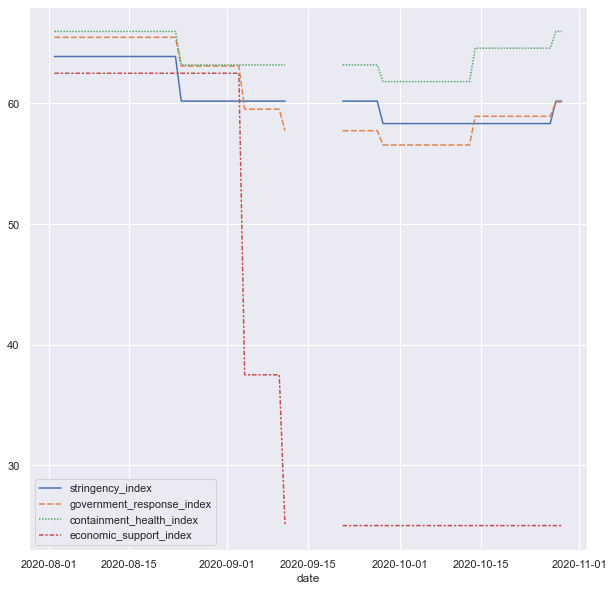

In [161]:
g = sns.lineplot(data=us[us.columns[1:5]])


In [217]:
df.Region.unique()

array(['Asia and the Pacific', 'Sub-Saharan Africa', 'Europe',
       'Middle East and North Africa', 'Americas',
       'Russia and Central Asia'], dtype=object)

In [91]:
df.groupby(["Subregion", "month"])["stringency_index", "government_response_index", "economic_support_index"].mean()

<ipython-input-91-ca17d795cced>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(["Subregion", "month"])["stringency_index", "government_response_index", "economic_support_index"].mean()


stringency_index  government_response_index  \
Subregion               month                                                
Australasia and Pacific 8             54.821056                  55.674111   
                        9             43.131778                  48.624611   
                        10            40.443017                  47.044804   
                        11            43.135000                  43.799167   
Caribbean               8             57.734333                  57.874286   
...                                         ...                        ...   
West Africa             11            36.388000                  43.095000   
Western Europe          8             49.107095                  59.190167   
                        9             48.826714                  59.003667   
                        10            53.185995                  61.781019   
                        11            63.687000                  69.337667   

                               economic_support_index  
Subregion               month                          
Australasia and Pacific 8                   60.416667  
                        9                   60.416667  
                        10                  60.405028  
                        11                  46.875000  
Caribbean               8                   42.380952  
...                                               ...  
West Africa             11                  20.833333  
Western Europe          8                   76.636905  
                        9                   74.522673  
                        10                  74.029126  
                        11                  70.416667  

[80 rows x 3 columns]

In [218]:
asia = df[(df.Region=="Asia and the Pacific") & (df.month==8)].groupby(["country", "month"]).max()
europe = df[(df.Region=="Europe") & (df.month==8)].groupby(["country", "month"]).max()

In [168]:
points = alt.Chart(asia.reset_index()).mark_point().encode(
    x='Political parity score:Q',
    y='stringency_index:Q'
)

text = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).encode(
    text='country'
)

points + text

alt.LayerChart(...)

In [181]:
plt.rcParams['figure.figsize'] = [15,10]

Text(0.5, 1.0, 'Asia in August: Political parity vs. stringency')

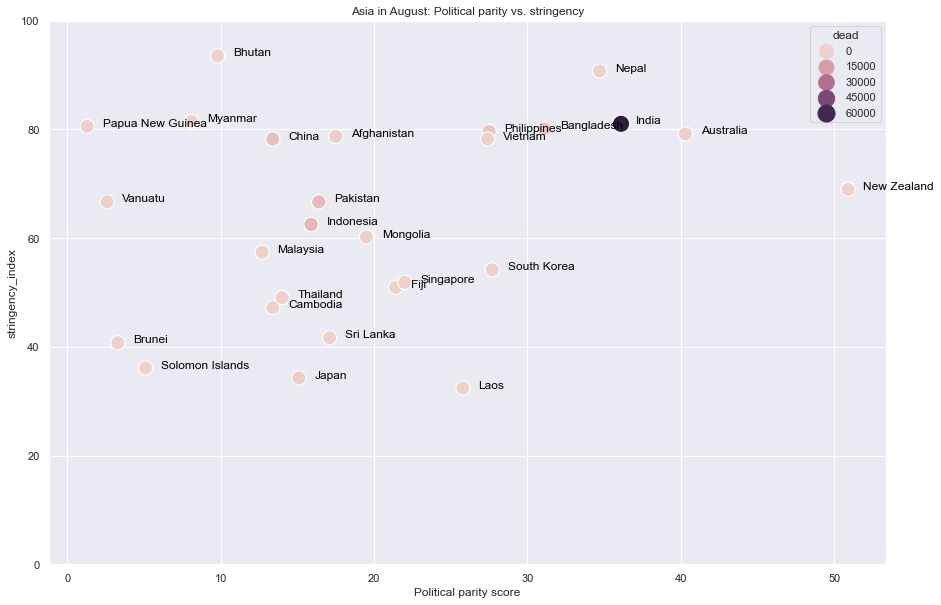

In [182]:
g = sns.scatterplot(
    data=asia, x="Political parity score", y="stringency_index", hue="dead", size="dead",
    sizes=(200, 300)
)


g.set(ylim=(0, 100))

for line in range(0,len(asia)):
    country, _ = asia.index[line]
    g.text(asia["Political parity score"][line]+1, 
                asia["stringency_index"][line], 
                country, 
                horizontalalignment='left', size='medium', color='black')
    
plt.title('Asia in August: Political parity vs. stringency')

Text(0.5, 1.0, 'Asia in August: Political parity vs. government response')

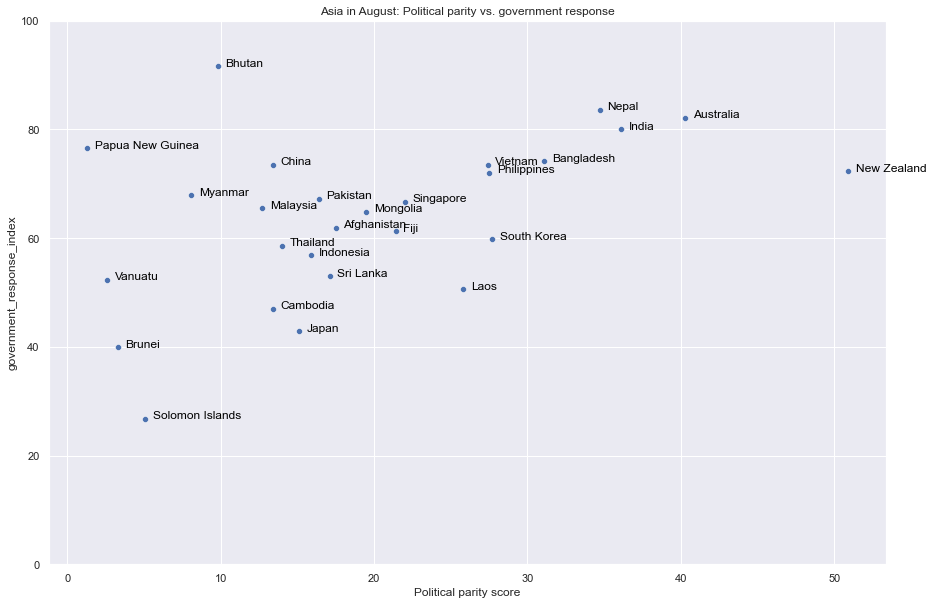

In [223]:
p1 = sns.scatterplot(
    data=asia, x="Political parity score", y="government_response_index",# hue="dead", size="dead",
    sizes=(50, 400)
)

p1.set(ylim=(0, 100))

for line in range(0,len(asia)):
    country, _ = asia.index[line]
    p1.text(asia["Political parity score"][line]+0.5, 
                asia["government_response_index"][line], 
                country, 
                horizontalalignment='left', size='medium', color='black')
    
plt.title('Asia in August: Political parity vs. government response')

Text(0.5, 1.0, 'Europe in August: Political parity vs. stringency_index')

posx and posy should be finite values
posx and posy should be finite values


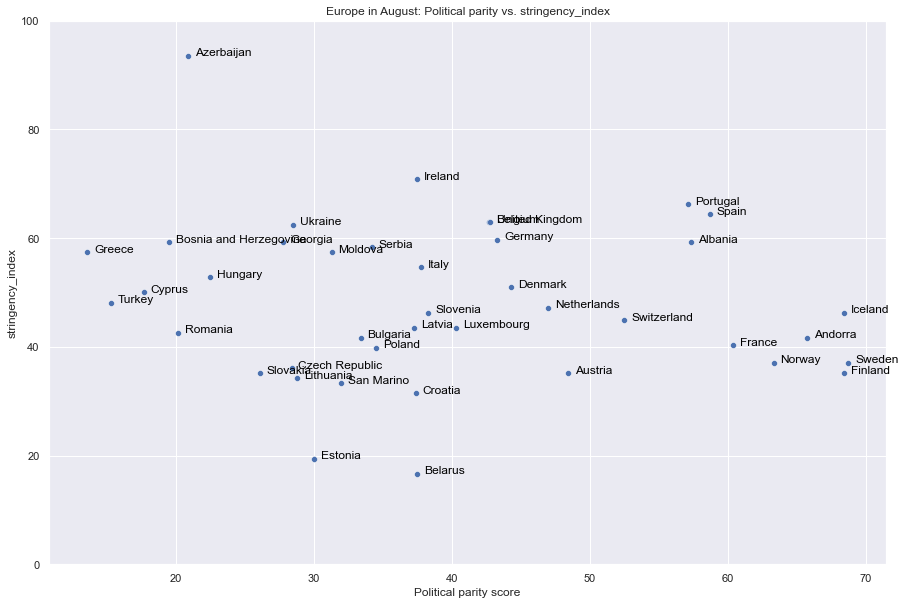

In [226]:
p1 = sns.scatterplot(
    data=europe, x="Political parity score", y="stringency_index",# hue="dead", size="dead",
    sizes=(50, 400)
)

p1.set(ylim=(0, 100))

for line in range(0,len(europe)):
    country, _ = europe.index[line]
    p1.text(europe["Political parity score"][line]+0.5, 
                europe["stringency_index"][line], 
                country, 
                horizontalalignment='left', size='medium', color='black')
    
plt.title('Europe in August: Political parity vs. stringency_index')

Text(0.5, 1.0, 'Europe in August: Political parity vs. government response')

posx and posy should be finite values
posx and posy should be finite values


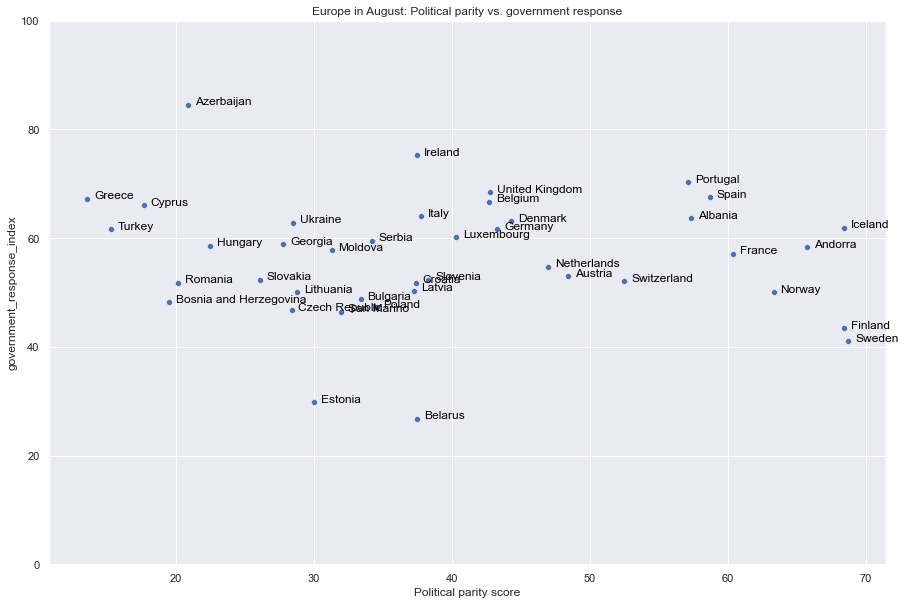

In [224]:
p1 = sns.scatterplot(
    data=europe, x="Political parity score", y="government_response_index",# hue="dead", size="dead",
    sizes=(50, 400)
)

p1.set(ylim=(0, 100))

for line in range(0,len(europe)):
    country, _ = europe.index[line]
    p1.text(europe["Political parity score"][line]+0.5, 
                europe["government_response_index"][line], 
                country, 
                horizontalalignment='left', size='medium', color='black')
    
plt.title('Europe in August: Political parity vs. government response')

In [225]:
# WOW Europe seems more ... linear

Text(0.5, 1.0, 'Asia in August: Political parity vs. dead')

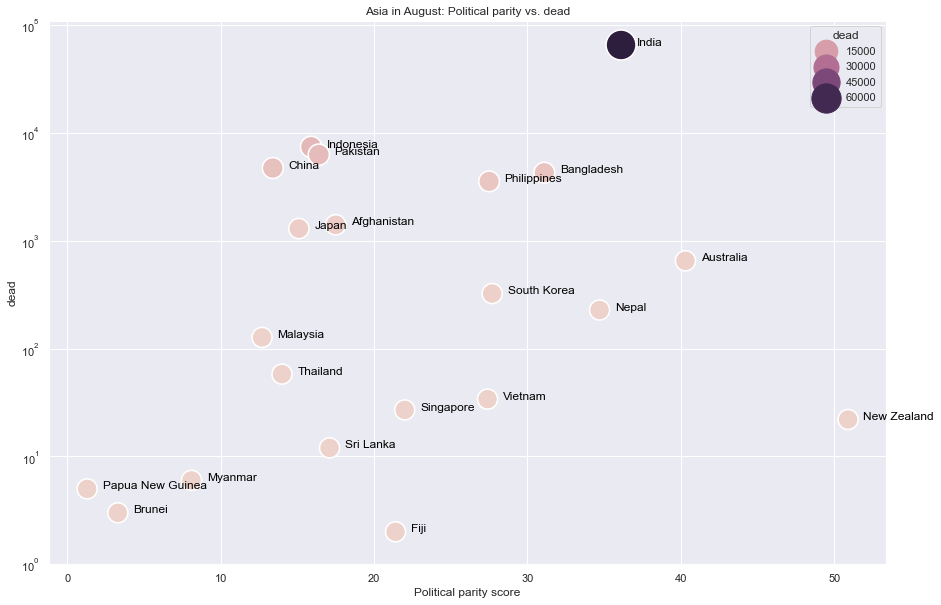

In [212]:
g = sns.scatterplot(
    data=asia[asia.dead>0], x="Political parity score", y="dead", hue="dead", size="dead",
    sizes=(400, 900)
)

g.set(yscale='log')
g.set(ylim=(1, None))

for line in range(0,len(asia[asia.dead>0])):
    country, _ = asia[asia.dead>0].index[line]
    g.text(asia[asia.dead>0]["Political parity score"][line]+1, 
                asia[asia.dead>0]["dead"][line], 
                country, 
                horizontalalignment='left', size='medium', color='black')
    
plt.title('Asia in August: Political parity vs. dead')

In [ ]:
asia = df[(df.Region=="Asia and the Pacific") & (df.month==8)].groupby(["country", "month"]).max()

In [ ]:
# Look by countries with more covid cases

## Discussion
What else can we use this for? 
Where else can this be used? 
Expansion

* Well, I used the max of government response, covid case number each month. I did that b/c it was easy to do that. Although ideally I'd do some sort of time series I guess
* missing data for some countries!! This is shown below:
* Unfortunately, WPI only measures countries in the UN ... so it does not have information on countries like Hong Kong and Taiwan
* Also unfortunately, Oxcovid is missing data from several countries. Not sure why. Need to look into that
* But I dropped all of those countries for this analysis


In [14]:
len(df['CountryName'].unique()), len(wpi['Country name'].unique())

(187, 194)

In [35]:
# In WPI but not in Oxcovid
set(wpi['Country name'].unique()) - set(df['country'].unique())

['Eswatini',
 'East Timor',
 'Samoa',
 'Tuvalu',
 'Grenada',
 'Armenia',
 'Bahamas',
 'Maldives',
 'Palau',
 'North Korea',
 'Liechtenstein',
 'Antigua and Barbuda',
 'Guinea-Bissau',
 'Micronesia',
 'Democratic Republic of Congo',
 'North Macedonia',
 'Malta',
 'Monaco',
 'Kiribati',
 'Ivory Coast',
 'Marshall Islands',
 'Tonga',
 'Nauru',
 'Saint Vincent and the Grenadines',
 'Saint Kitts and Nevis',
 'Montenegro',
 'Sao Tome and Principe',
 'Saint Lucia',
 'Equatorial Guinea']

In [19]:
# in oxcovid but not in wpi
# politically ... problemtatic?
set(df['country'].unique()) - set(wpi['Country name'].unique())

{'Anguilla',
 'Aruba',
 'Bermuda',
 'British Virgin Islands',
 'Cayman Islands',
 'Congo',
 "Cote d'Ivoire",
 'Falkland Islands',
 'Gibraltar',
 'Greenland',
 'Guam',
 'Hong Kong',
 'Kyrgyz Republic',
 'Macao',
 'Montserrat',
 'Palestine',
 'Pitcairn Islands',
 'Puerto Rico',
 'Slovak Republic',
 'Taiwan',
 'Timor-Leste',
 'Turks and Caicos Islands',
 'United States Virgin Islands'}

In [112]:
df_group = df.groupby("CountryName").mean()
df_group = df_group.merge(dead, left_index=True, right_on="country")

In [149]:
df_group = df_group[df_group.dead != 0]
df_group["dead_log"] = np.log(df_group["dead"])

In [84]:
plt.rcParams['figure.figsize'] = [15, 8]

In [150]:
df_group[["dead", "dead_log"]].head(10)

,dead,dead_log
country,,
Afghanistan,1556.0,7.349874
Albania,549.0,6.308098
Algeria,2024.0,7.612831
Andorra,75.0,4.317488
Angola,300.0,5.703782
Argentina,33136.0,10.408376
Aruba,39.0,3.663562
Australia,909.0,6.812345
Austria,1377.0,7.227662


Text(0.5, 1.0, 'Political parity vs. stringency')

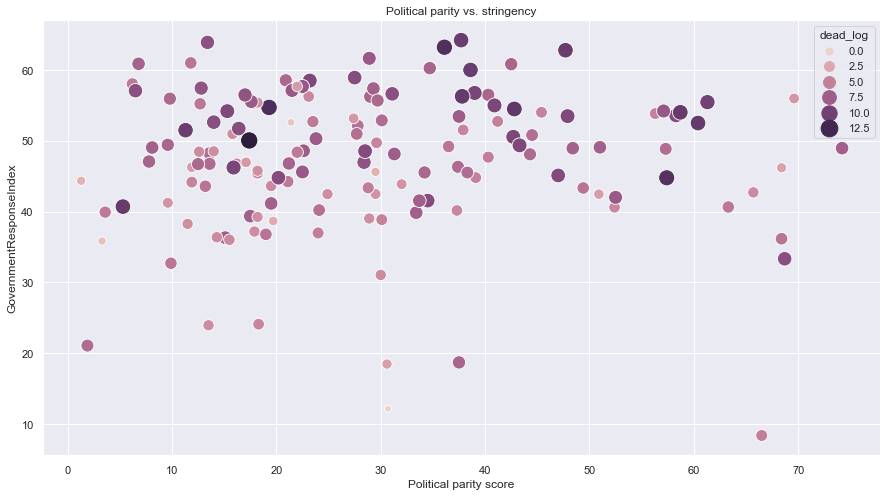

In [158]:
sns.scatterplot(
    data=df_group, x="Political parity score", y="GovernmentResponseIndex", hue="dead_log", size="dead_log",
    sizes=(50, 300)
)

plt.title('Political parity vs. stringency')

Text(0.5, 1.0, 'Political parity vs. dead')

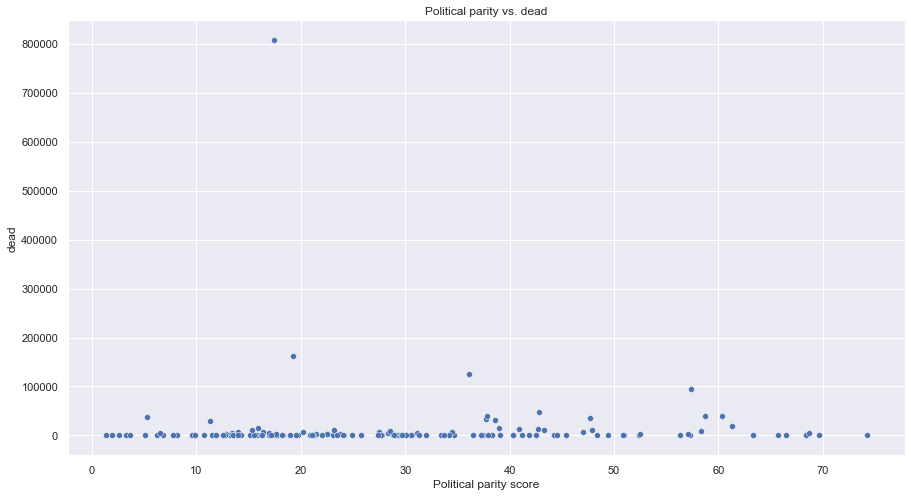

In [128]:
g = sns.scatterplot(
    data=df_group, x="Political parity score", y="dead", 
)

# g.set_yscale("log")

plt.title('Political parity vs. dead')

TypeError: 'Text' object is not callable

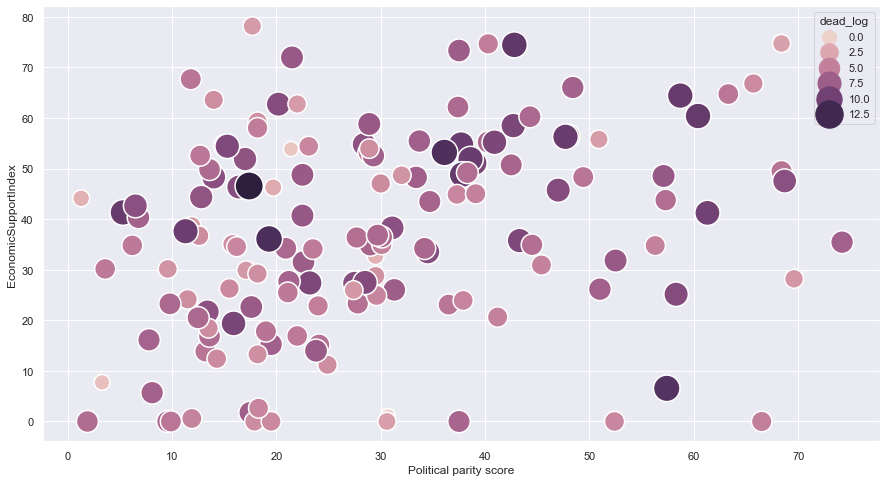

In [161]:
plt = sns.scatterplot(
    data=df_group, x="Political parity score", y="EconomicSupportIndex", hue="dead_log", size="dead_log",
    sizes=(200, 800)
)

plt.title('Political parity vs. economic support')

In [178]:
df_group.index

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Argentina',
       'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       ...
       'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay',
       'Uzbekistan', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', name='country', length=161)

In [185]:
df_group = df_group[~df_group["Political parity score"].isna()]
df_group = df_group[~df_group["GovernmentResponseIndex"].isna()]

Text(0.5, 1.0, 'Political parity vs. GovernmentResponseIndex')

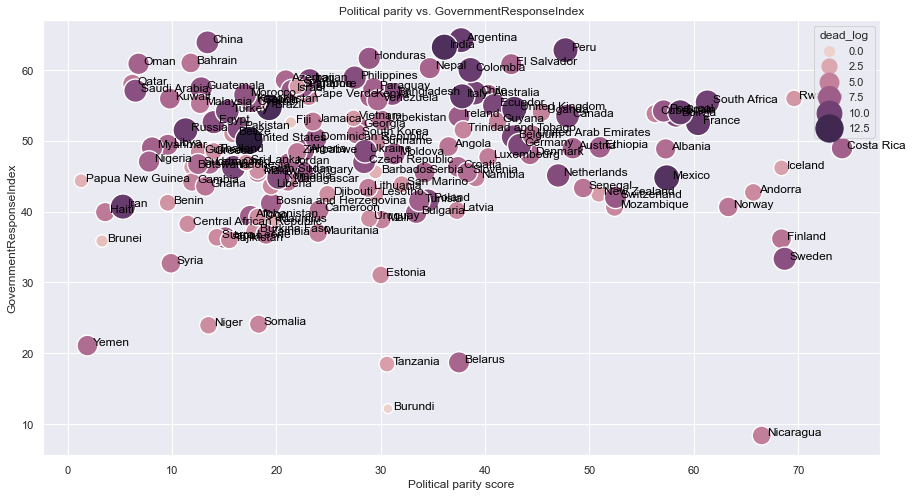

In [191]:
p1 = sns.scatterplot(
    data=df_group, x="Political parity score", y="GovernmentResponseIndex", hue="dead_log", size="dead_log",
    sizes=(100, 800)
)

for line in range(0,df_group.shape[0]):
     p1.text(df_group["Political parity score"][line]+0.5, 
                df_group["GovernmentResponseIndex"][line], 
                df_group.index[line], 
                horizontalalignment='left', size='medium', color='black')

plt.title('Political parity vs. GovernmentResponseIndex')

<AxesSubplot:xlabel='Political parity score', ylabel='C1_School closing'>

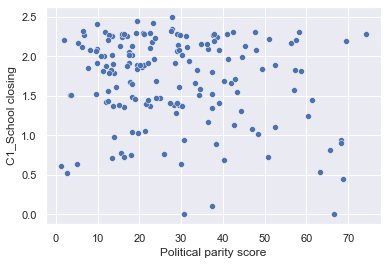

In [42]:
sns.scatterplot(
    data=df.groupby("CountryName").mean(), x="Political parity score", y="C1_School closing"#, hue="size", size="size",
    #sizes=(20, 200), legend="full"
)

<AxesSubplot:xlabel='Political parity score', ylabel='C2_Workplace closing'>

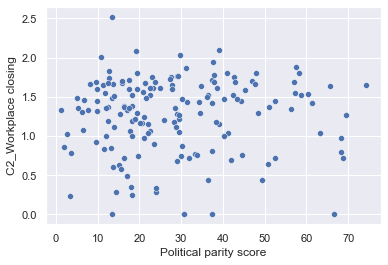

In [43]:
sns.scatterplot(
    data=df.groupby("CountryName").mean(), x="Political parity score", y="C2_Workplace closing"#, hue="size", size="size",
    #sizes=(20, 200), legend="full"
)

<AxesSubplot:xlabel='Political parity score', ylabel='EconomicSupportIndex'>

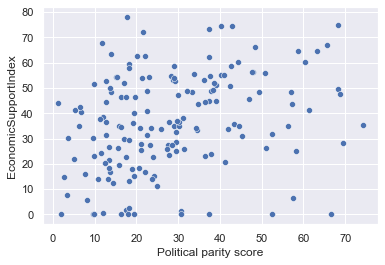

In [45]:
sns.scatterplot(
    data=df.groupby("CountryName").mean(), x="Political parity score", y="EconomicSupportIndex"#, hue="size", size="size",
    #sizes=(20, 200), legend="full"
)

<AxesSubplot:xlabel='Political parity score', ylabel='E1_Income support'>

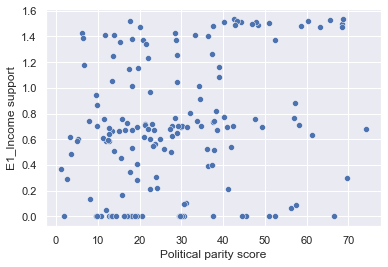

In [48]:
sns.scatterplot(
    data=df.groupby("CountryName").mean(), x="Political parity score", y='E1_Income support'#, hue="size", size="size",
    #sizes=(20, 200), legend="full"
)